In [1]:
#!pip install keras

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from tensorflow.keras import backend as K
from keras.models import load_model
import util
from public_tests import *
from test_utils import *
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

2024-11-12 13:53:23.872129: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


The dataset includes a CSV file that provides the labels for each X-ray. 

To make your job a bit easier, we have processed the labels for our small sample and generated three new files to get you started. These three files are:

1. `nih/train-small.csv`: 875 images from our dataset to be used for training.
1. `nih/valid-small.csv`: 109 images from our dataset to be used for validation.
1. `nih/test.csv`: 420 images from our dataset to be used for testing. 

This dataset has been annotated by consensus among four different radiologists for 5 of our 14 pathologies:
- `Consolidation`
- `Edema`
- `Effusion`
- `Cardiomegaly`
- `Atelectasis`

# Load Dataset

In [3]:
train_df = pd.read_csv("data/nih/train-small.csv")
valid_df = pd.read_csv("data/nih/valid-small.csv")
test_df = pd.read_csv("data/nih/test.csv")
train_df.head()

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0,0,0,0,0,0,0,0,0,0,0,8270,0,0,0
1,00029855_001.png,1,0,0,0,1,0,0,0,1,0,0,29855,0,0,0
2,00001297_000.png,0,0,0,0,0,0,0,0,0,0,0,1297,1,0,0
3,00012359_002.png,0,0,0,0,0,0,0,0,0,0,0,12359,0,0,0
4,00017951_001.png,0,0,0,0,0,0,0,0,1,0,0,17951,0,0,0


In [4]:
labels = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']

#### Fix Leakage

In [5]:
def check_for_leakage(df1, df2, patient_col):
    """
    Return True if there any patients are in both df1 and df2.

    Args:
        df1 (dataframe): dataframe describing first dataset
        df2 (dataframe): dataframe describing second dataset
        patient_col (str): string name of column with patient IDs
    
    Returns:
        leakage (bool): True if there is leakage, otherwise False
    """
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    #df1_patients_unique = set(df1[patient_col].unique())
    #df2_patients_unique = set(df2[patient_col].unique())
    df1_patients_unique = set(df1[patient_col])
    df2_patients_unique = set(df2[patient_col])
    
    #
    patients_in_both_groups = df1_patients_unique.intersection(df2_patients_unique)
    # leakage contains true if there is patient overlap, otherwise false.
    len_patients = len(patients_in_both_groups)
    leakage = True if len_patients > 0 else False # boolean (true if there is at least 1 patient in both groups)
    return leakage

In [6]:
### do not edit this code cell    
check_for_leakage_test(check_for_leakage)

Test Case 1

df1
   patient_id
0           0
1           1
2           2
df2
   patient_id
0           2
1           3
2           4
leakage output: True 
-------------------------------------
Test Case 2

df1
   patient_id
0           0
1           1
2           2
df2
   patient_id
0           3
1           4
2           5
leakage output: False 

 All tests passed.


In [7]:
print("leakage between train and valid: {}".format(check_for_leakage(train_df, valid_df, 'PatientId')))
print("leakage between train and test: {}".format(check_for_leakage(train_df, test_df, 'PatientId')))
print("leakage between valid and test: {}".format(check_for_leakage(valid_df, test_df, 'PatientId')))

leakage between train and valid: True
leakage between train and test: False
leakage between valid and test: False


---
---
### Prepare Images 

In [8]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for training set, normalizing using batch
    statistics.

    Args:
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        train_generator (DataFrameIterator): iterator over training set
    """        
    print("getting train generator...") 
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

In [9]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for validation set and test set using 
    normalization statistics from training set.

    Args:
      valid_df (dataframe): dataframe specifying validation data.
      test_df (dataframe): dataframe specifying test data.
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        test_generator (DataFrameIterator) and valid_generator: iterators over test set and validation set respectively
    """
    print("getting train and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=IMAGE_DIR, 
        x_col="Image", 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    # get data sample
    batch = next(raw_train_generator)
    data_sample = batch[0]
    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    # fit generator to sample from training data
    image_generator.fit(data_sample)
    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    #test_generator_image
    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

In [10]:
IMAGE_DIR = "data/nih/images-small/"
train_generator = get_train_generator(train_df, IMAGE_DIR, "Image", labels)
valid_generator, test_generator= get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "Image", labels)

getting train generator...
Found 1000 validated image filenames.
getting train and valid generators...
Found 1000 validated image filenames.
Found 1 validated image filenames.
Found 420 validated image filenames.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 108 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


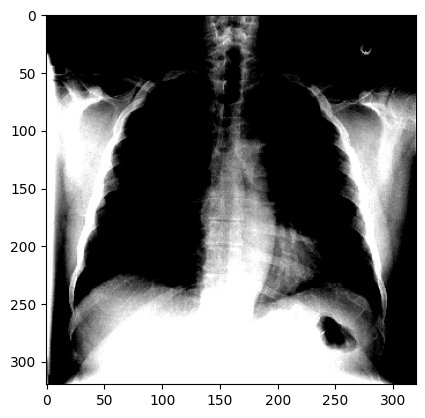

In [11]:
x, y = train_generator.__getitem__(0)
plt.imshow(x[0]);

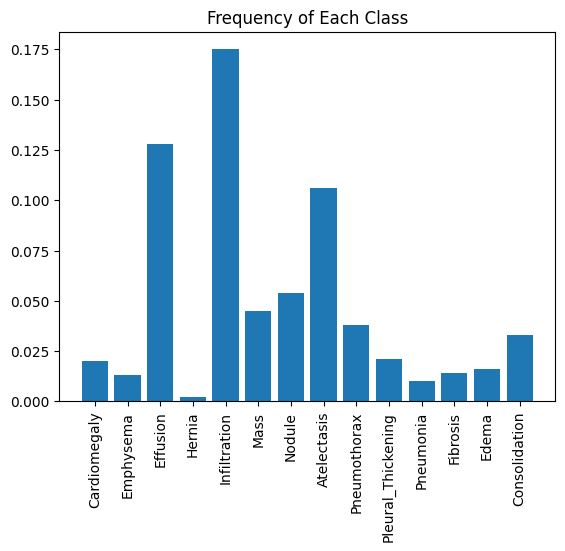

In [12]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

In [13]:
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    # total number of patients (rows)
    N = labels.shape[0]
    positive_frequencies = np.sum(labels, axis=0)/N
    negative_frequencies = np.sum(np.where(labels == 0, 1, 0), axis=0)/N
    ### END CODE HERE ###
    return positive_frequencies, negative_frequencies

In [14]:
### do not edit this code cell       
compute_class_freqs_test(compute_class_freqs)

Labels:
[[1 0 0]
 [0 1 1]
 [1 0 1]
 [1 1 1]
 [1 0 1]]

Pos Freqs:  [0.8 0.4 0.8]
Neg Freqs:  [0.2 0.6 0.2] 

 All tests passed.


In [15]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

array([0.02 , 0.013, 0.128, 0.002, 0.175, 0.045, 0.054, 0.106, 0.038,
       0.021, 0.01 , 0.014, 0.016, 0.033])

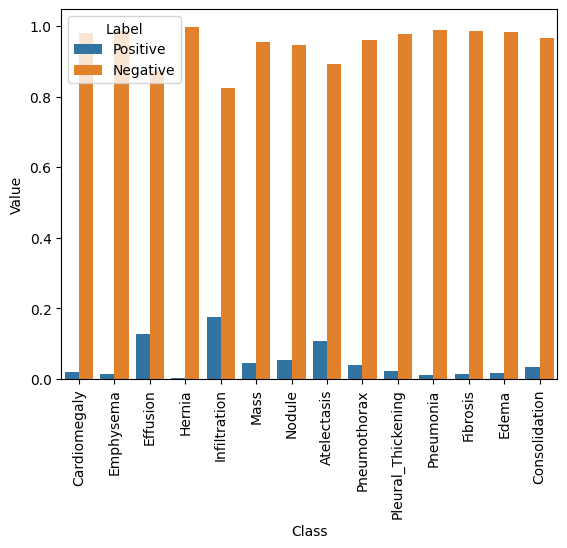

In [16]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = pd.concat([data,pd.DataFrame([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)])], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

,Class,Label,Value
0,Cardiomegaly,Positive,0.020
1,Emphysema,Positive,0.013
2,Effusion,Positive,0.128
3,Hernia,Positive,0.002
4,Infiltration,Positive,0.175


In [17]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

In [18]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0

        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            tmp_pos = -1 * tf.keras.backend.mean(pos_weights[i]* (y_true[:, i]*tf.keras.backend.log(y_pred[:, i] + epsilon)))
            tmp_neg = -1 * tf.keras.backend.mean(neg_weights[i] *((1- y_true[:, i])*tf.keras.backend.log((1- y_pred[:, i]) + epsilon)))
            loss += tmp_pos + tmp_neg 
            #print(loss)
            
        return loss
    
    return weighted_loss

In [19]:
# test with a large epsilon in order to catch errors. 
# In order to pass the tests, set epsilon = 1
epsilon = 1

### do not edit anything below
sess = tf.compat.v1.Session() 
#get_weighted_loss_test(get_weighted_loss, epsilon, sess)

In [20]:
# create the base pre-trained model
base_model = DenseNet121(weights='models/nih/densenet.hdf5', include_top=False)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights))

In [21]:
from datetime import datetime 
  


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - loss: 0.9591

2024-11-12 14:05:21.832813: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 709s 7s/step - loss: 0.9588 - val_loss: 14.3964
Epoch 2/3


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


 25/100 ━━━━━━━━━━━━━━━━━━━━ 8:50 7s/step - loss: 0.8538

2024-11-12 14:08:18.295011: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - loss: 0.8425 - val_loss: 14.3663
Epoch 3/3


2024-11-12 14:08:18.559431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 649s 6s/step - loss: 0.8773 - val_loss: 16.2237


2024-11-12 14:19:07.201967: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


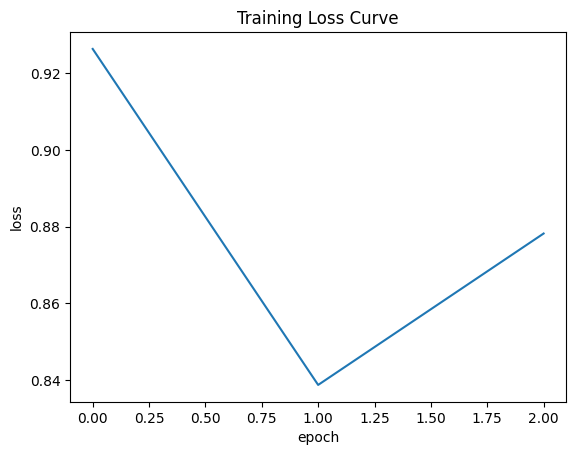

difference in seconds is: 1534.632581
difference in minutes is: 25.577209683333333
difference in hours is: 0.42628682805555557


In [22]:
start = datetime.now()
history = model.fit(train_generator, 
                              validation_data=valid_generator,
                              steps_per_epoch=100, 
                              validation_steps=25, 
                              epochs = 3)

plt.plot(history.history['loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()
end = datetime.now()
difference = end - start 
  
seconds = difference.total_seconds() 
print('difference in seconds is:', seconds) 
minutes = seconds / 60
print('difference in minutes is:', minutes) 
  
hours = seconds / (60 * 60) 
print('difference in hours is:', hours)

In [23]:
history.history

{'loss': [0.9263913035392761, 0.8387075066566467, 0.8782190680503845],
 'val_loss': [14.39636516571045, 14.366275787353516, 16.22373390197754]}

In [24]:
model.load_weights("models/nih/pretrained_model.h5")

In [25]:
predicted_vals = model.predict(test_generator, steps = len(test_generator))

53/53 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step


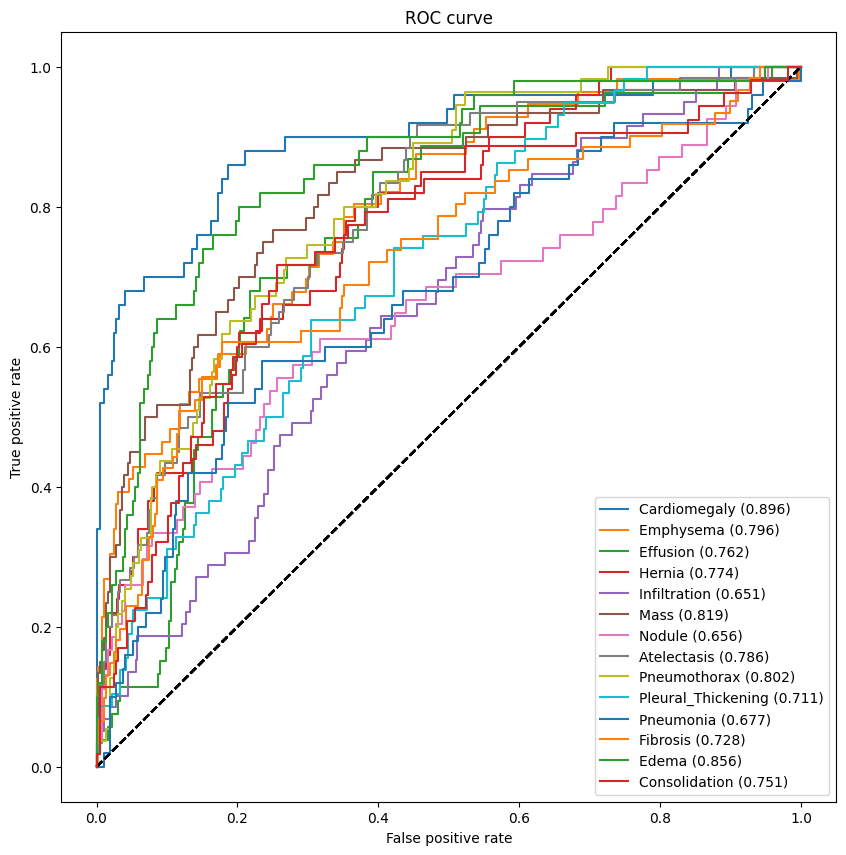

In [26]:
auc_rocs = util.get_roc_curve(labels, predicted_vals, test_generator)

In [27]:
df = pd.read_csv("data/nih/train-small.csv")
IMAGE_DIR = "data/nih/images-small/"

# only show the labels with top 4 AUC
labels_to_show = np.take(labels, np.argsort(auc_rocs)[::-1])[:4]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Loading original image
Generating gradcam for class Cardiomegaly


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: [['keras_tensor']]. Received: the structure of inputs=*
  warnings.warn(


Generating gradcam for class Mass
Generating gradcam for class Pneumothorax
Generating gradcam for class Edema


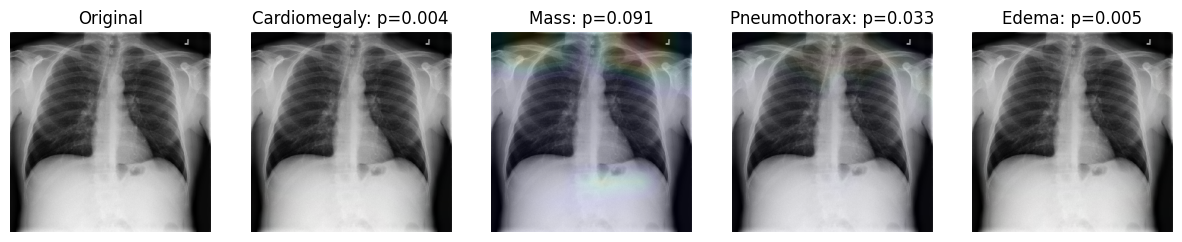

In [28]:
util.compute_gradcam(model, '00008270_015.png', IMAGE_DIR, df, labels, labels_to_show)

In [45]:
train_df[train_df['Image']== '00008270_015.png']

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0,0,0,0,0,0,0,0,0,0,0,8270,0,0,0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Loading original image
Generating gradcam for class Cardiomegaly


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: [['keras_tensor']]. Received: the structure of inputs=*
  warnings.warn(


Generating gradcam for class Mass
Generating gradcam for class Pneumothorax
Generating gradcam for class Edema


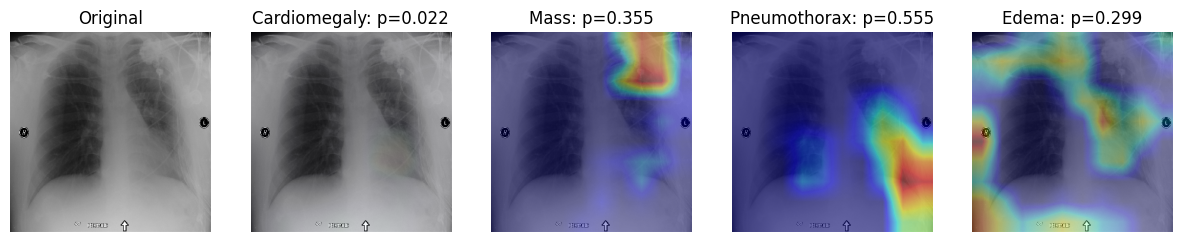

In [42]:
util.compute_gradcam(model, '00011355_042.png', IMAGE_DIR, df, labels, labels_to_show)

In [43]:
train_df[train_df['PatientId']==11355] 

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
737,00011355_002.png,0,0,0,0,0,1,0,0,0,0,0,11355,0,0,0
859,00011355_042.png,0,0,0,0,0,0,0,0,0,1,0,11355,0,0,0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
Loading original image
Generating gradcam for class Cardiomegaly
Generating gradcam for class Mass
Generating gradcam for class Pneumothorax
Generating gradcam for class Edema


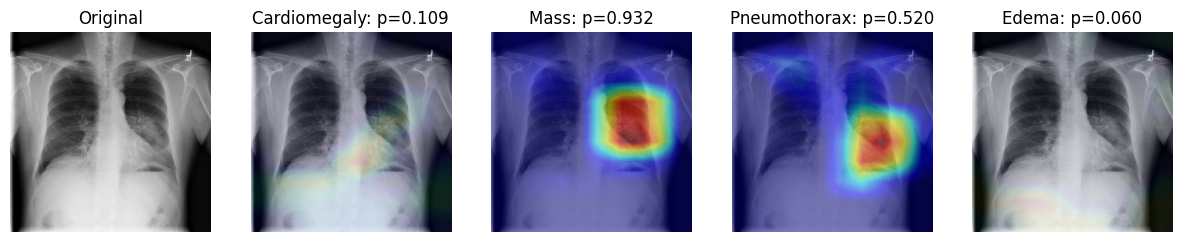

In [30]:
util.compute_gradcam(model, '00000103_000.png', IMAGE_DIR, df, labels, labels_to_show)

In [40]:
train_df[train_df['PatientId']==103] 

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
823,00000103_000.png,0,0,0,0,0,0,0,0,0,1,0,103,0,0,0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Loading original image
Generating gradcam for class Cardiomegaly
Generating gradcam for class Mass
Generating gradcam for class Pneumothorax
Generating gradcam for class Edema


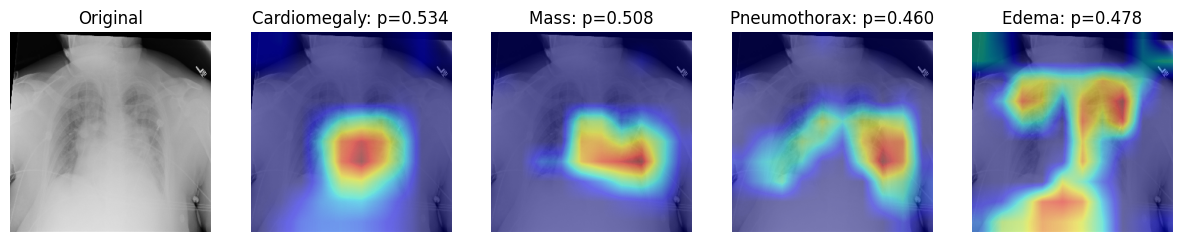

In [31]:
util.compute_gradcam(model, '00001232_002.png', IMAGE_DIR, df, labels, labels_to_show)

For details about the best performing methods and their performance on this dataset, we encourage you to read the following papers:
- [CheXNet](https://arxiv.org/abs/1711.05225)
- [CheXpert](https://arxiv.org/pdf/1901.07031.pdf)
- [ChexNeXt](https://journals.plos.org/plosmedicine/article?id=10.1371/journal.pmed.1002686)

In [33]:
train_df.head()

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0,0,0,0,0,0,0,0,0,0,0,8270,0,0,0
1,00029855_001.png,1,0,0,0,1,0,0,0,1,0,0,29855,0,0,0
2,00001297_000.png,0,0,0,0,0,0,0,0,0,0,0,1297,1,0,0
3,00012359_002.png,0,0,0,0,0,0,0,0,0,0,0,12359,0,0,0
4,00017951_001.png,0,0,0,0,0,0,0,0,1,0,0,17951,0,0,0


In [39]:
train_df[train_df['PatientId']== 1232]

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
5,00001232_002.png,1,1,0,0,1,0,0,0,1,0,0,1232,0,0,0
